# 4. Bayesian Networks

## Preamble

In [1]:
import os
import ipykernel
import ipywidgets as widgets
from notebook import notebookapp
import urllib
import json

import logging
logging_setup = False

# Functions below based on 
# https://stackoverflow.com/questions/12544056/how-do-i-get-the-current-ipython-jupyter-notebook-name
def get_kernel_id():
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]
    return kernel_id

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    kernel_id = get_kernel_id()
    
    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
        
    return None

In [2]:
print(f'connect to this kernel with:\n  jupyter console --existing {get_kernel_id()}')

connect to this kernel with:
  jupyter console --existing 965732d8-9276-4cfd-b7d3-ae732b24f5cd


In [3]:
if logging_setup == False:
    log = logging.getLogger()

    # handler = OutputWidgetHandler()
    logfile = os.path.splitext(notebook_path())[0] + '.log'
    
    # Delete the logfile to start fresh.
    # Use tail -F to follow the file regardless :-)
    try:
       os.remove(logfile)
    except:
       pass

    with open(logfile, 'w') as fp:
        fp.write('\n')

    handler = logging.FileHandler(logfile)
    handler.setFormatter(
        logging.Formatter(
            '%(asctime)s  - %(name)-14s - [%(levelname)s] %(message)s',
            "%Y-%m-%d %H:%M:%S")
    )
    log.addHandler(handler)
    log.setLevel(logging.INFO)
    logging_setup = True

log.info('-' * 60)
log.info('Starting the notebook!!')
log.info('-' * 60)

In [4]:
# handler.clear_logs()
# for x in range(200):
#     log.debug(f'{x:02}: yeaj')

## Notebook

In [5]:
import numpy as np
import pandas as pd
import lark

import thomas.core
from thomas.core import BayesianNetwork
from thomas.core import examples
from thomas.core.reader import oobn

from IPython.display import display, HTML

print(f'Using thomas.core version: {thomas.core.__version__}')
print(f'Using Pandas version: {pd.__version__}')
print(f'Current working directory:\n  {os.getcwd()}')

Using thomas.core version: 2020-03-02 20:21
Using Pandas version: 1.0.1
Current working directory:
  /Users/melle/python_projects/thomas/thomas-core/notebooks


In [6]:
thomas_log = logging.getLogger('thomas')
thomas_log.setLevel(logging.DEBUG)

In [7]:
# Load the Student Network from the examples
Gs = examples.get_student_network()
Gs

<BayesianNetwork name='Student'>
  <Node RV='I' states=['i0', 'i1'] />
  <Node RV='S' states=['s0', 's1'] />
  <Node RV='D' states=['d0', 'd1'] />
  <Node RV='G' states=['g1', 'g2', 'g3'] />
  <Node RV='L' states=['l0', 'l1'] />
</BayesianNetwork>

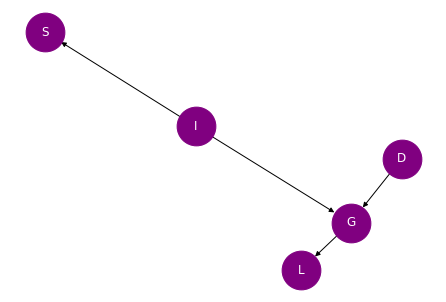

In [8]:
# Show the network and its relations
Gs.draw()

In [9]:
# Accessing individual Nodes/CPTs is easy
Gs['S'].cpt

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [10]:
# Querying the network is also simple. To compute the marginals over I, S and D:
Gs.compute_marginals(['I', 'S', 'D'])

{'I': factor(I)
 I
 i0    0.7
 i1    0.3
 dtype: float64,
 'S': factor(S)
 S
 s0    0.725
 s1    0.275
 dtype: float64,
 'D': factor(D)
 D
 d0    0.6
 d1    0.4
 dtype: float64}

In [11]:
# To compute the marginals over I, S and D given evidence I=i0:
Gs.compute_marginals(['I', 'S', 'D'], {'I':'i0'})

{'I': factor(I)
 I
 i0    1.0
 i1    0.0
 dtype: float64,
 'S': factor(S)
 S
 s0    0.95
 s1    0.05
 dtype: float64,
 'D': factor(D)
 D
 d0    0.6
 d1    0.4
 dtype: float64}

In [12]:
# Complex queries can be run simply by providing the query as string:
Gs.P('I=i0|S')

I,i0
S,
s0,0.917241
s1,0.127273


In [13]:
# This should be equal to Gs['S'] 
Gs.P('S|I')

S,s0,s1
I,,
i0,0.95,0.05
i1,0.20,0.80


In [14]:
# Alternatively, parameters can be specified separately through 
# `compute_posterior()`:
Gs.compute_posterior(qd=['I'], qv={}, ed=['S'], ev={})

I,i0,i1
S,,
s0,0.917241,0.082759
s1,0.127273,0.872727


In [15]:
# A CPT can be converted to a pandas.DataFrame by calling `unstack()` without
# parameters. Note that this only works if there are conditioning variables.
unstacked = Gs.P('I|S').unstack()
print(f'type(unstacked): {type(unstacked)}')
print()
display(unstacked)

type(unstacked): <class 'pandas.core.frame.DataFrame'>



I,i0,i1
S,,
s0,0.917241,0.082759
s1,0.127273,0.872727


In [16]:
# Nodes can be accessed by using the BN as a `dict`:
node = Gs['S']
node

DiscreteNetworkNode('S', name='S', states=['s0', 's1'])

In [17]:
# The Node-property 'states' will return a list of allowed states.
Gs['S'].states

['s0', 's1']

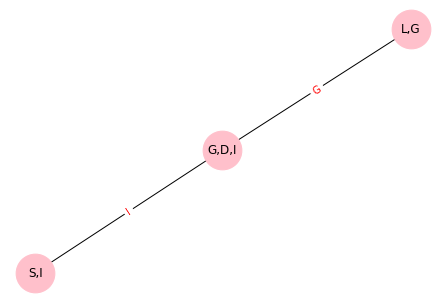

In [18]:
# The junction tree (jointree) can be inspected by calling `jt.draw()`:
Gs.jt.draw()